# Interactive Demo 

*Elaborated by Renata B. Magro*

## Introduction
River gauges (monitoring stations) are tools for monitoring hydrological variables and understanding the dynamics of river systems and floodwater. 

However, their distribution across river networks is often sparse, leading to the question of whether the existing network of monitoring stations effectively captures the hydrological, morphological, and environmental diversity inherent in river basins.

> The objetive of this notebook is to demonstrate how different parameter configurations impact the flood susceptibility model and the placement of monitoring stations.


### Summary of parameters 
This analysis depends on multiple heterogeneous input data and parameters that can be modified to assess different scenarios. The table below summarizes the key inputs, adjustable parameters, and outputs of the process:

| **Category**          | **Parameter**                | **Description**                                      | **Impact** |
|----------------------|----------------------------|--------------------------------------------------|---------|
| **Input**           | *Digital Elevation Model (DEM)* | Raster containing terrain elevation data       | Defines topography and drainage patterns |
|                    | *Flow Direction (FDIR)*   | Grid indicating the direction of water flow per cell | Controls water routing |
|                    | *Flow Accumulation (ACC)* | Raster representing cumulative upstream flow   | Determines drainage paths |
| **Adjustable Parameters** | *Flow accumulation threshold* | Minimum ACC value to define river networks | Lower values = denser stream networks, higher values = generalized drainage paths |
|                    | *Scenario*               | Type of analysis (e.g., flood inundation vs. susceptibility) | Represents demand scenarios based on different modeling approaches |
|                    | *DEM resolution*         | Spatial resolution of the DEM raster          | Higher resolution = more detail, but increased computational cost |
|                    | *Number of demand points* | Number of locations considered for monitoring | Affects allocation strategy |
|                    | *Coverage radius (S)*    | Maximum distance a station can cover          | Larger values = fewer stations required |
|                    | *Maximum number of stations (p)* | Upper limit on selected stations | Directly affects network density |
| **Output**         | *River Network*    | Extracted river network from ACC threshold    | Used to compute HAND |
|                    | *Flood Susceptibility Map* | HAND-based classification of flood-prone areas | Indicates flood susceptibility zones for hydrological monitoring |
|                    | *Optimized Gauge Placement* | Locations of selected monitoring stations  | Robustness of flood monitoring networks |




What can be modified in this notebook?

- flow accumulation threshold (primary control for river network extraction)
- demand-based scenario 

In [ ]:
# Pacotes necessarios
#
#!pip install numpy pandas geopandas pysheds seaborn matplotlib ipywidgets shapely

## Step 1. Calculating Flood Suscetibility with HAND model

**Context:** The **Heigh Above Nearest Drainage (HAND) model** is a topographic-based approach for assessing flood susceptibility.  

It assumes that areas at lower elevations near the river network are more prone to flooding, while higher areas are less susceptible. Here, we are using a 30m-resoltuion DEM from SRTM.

- By computing HAND values, we generate a spatial representation of flood susceptibility across the study area.

| **Susceptibility level**  | **Description** |
|--------------------------|---------------|
| **Low**                  | Higher elevations, far from drainage |
| **Medium**               | Transitional areas with moderate elevation differences |
| **High**                 | Low-lying areas near the river network |

>For more details, refers to *[Cuartas, L. A., Nobre, A. D., Hodnett, M. et al., 2012](https://doi.org/10.1016/j.jhydrol.2011.03.051)*. *Distributed hydrological modeling of a micro-scale rainforest watershed in Amazonia: Model evaluation and advances in calibration using the new HAND terrain model*. Journal of Hydrology: 404, 13–29.

- Below, you can adjust the **flow accumulation threshold** to observe its impact on river network delineation and flood susceptibility mapping.


In [3]:
# Import packages

import pysheds
import os 
from pysheds.grid import Grid
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

%matplotlib inline

In [4]:
# Set directory

path_dir = "/Users/macbook-c4ai3/jupyter/sensors-optimization/dashboard"
os.chdir(path_dir)

#print("Diretório atual:", os.getcwd())

In [7]:
# Open a Digital Elevation Model 

grid = Grid.from_raster('data/raster/strm_90m_utm.tif', data_name='dem', nodata_out=np.int64(0))
dem = grid.read_raster('data/raster/strm_90m_utm.tif', nodata=grid.nodata)

# Resolve depressions and flats 
flooded_dem = grid.fill_depressions(dem)
inflated_dem = grid.resolve_flats(flooded_dem)

# Compute flow direction
fdir = grid.flowdir(inflated_dem, nodata_out=np.int64(0))

In [8]:
# Define the flow direction network sense

#           #N    NE    E    SE    S    SW    W    NW
# dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

In [9]:
# Compute flow accumulation
#acc = grid.accumulation(fdir, dirmap=dirmap, pad_inplace = False)
acc = grid.accumulation(fdir, pad_inplace = False)

In [12]:
import seaborn as sns
import ipywidgets as widgets
from pysheds.grid import Grid
from IPython.display import display

# Especificar coordenadas do exutório
x, y = 490966.4834, 6332012.2645

# Criar um widget para ajustar o parâmetro de acumulação de fluxo
acc_threshold = widgets.IntSlider(
    value=500,  # Valor inicial
    min=500,     # Mínimo possível
    max=25000,    # Máximo possível
    step=500,    # Passo de ajuste
    description='Flow acc threshold:',
    continuous_update=False,
    layout=widgets.Layout(width='600px'), 
    style={'description_width': 'initial'}
)

# Criar a função para atualizar a visualização
def update_hand(threshold):
    # Calcular HAND com o valor escolhido pelo usuário
    hand = grid.compute_hand(fdir, dem, acc > threshold)

    # Delimitar a bacia hidrográfica
    catch = grid.catchment(x=x, y=y, fdir=fdir, xytype='coordinate')
    grid.clip_to(catch)

    # Criar uma visualização do HAND
    hand_view = grid.view(hand, nodata=np.nan)

    # Criar o gráfico
    fig, ax = plt.subplots(figsize=(8,4.5))
    fig.patch.set_alpha(0)
    plt.imshow(hand_view, extent=grid.extent, cmap='terrain', zorder=1)
    plt.colorbar(label='Elevation (m)')
    plt.grid(zorder=0, alpha=0.3)
    plt.title(f'HAND raster (Flow Acc > {threshold})', size=12, fontweight='bold')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.tight_layout()
    plt.show()

# Conectar o slider à função de atualização
widgets.interactive(update_hand, threshold=acc_threshold)

interactive(children=(IntSlider(value=500, continuous_update=False, description='Flow acc threshold:', layout=…

## Step 2. Extracting drainage river network

**Context:** the flow accumulation threshold is a primary control for delineating the river network:
>Lower values → Capture smaller streams and tributaries, resulting in a more detailed network
>
>Higher values → Focus on major channels, simplifying the network

- Below, users can **adjust the flow accumulation threshold** to observe how different values impact the extracted river network.


In [16]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from pysheds.grid import Grid

###----- Data already imported from previous step -----###

# # Define directory
# path_dir = "/Users/macbook-c4ai3/jupyter/sensors-optimization"
# os.chdir(path_dir)

# Data
#grid = Grid.from_raster('data/raster/strm_90m_utm.tif', data_name='dem', nodata_out=np.int64(0))
#dem = grid.read_raster('data/raster/strm_90m_utm.tif', nodata=grid.nodata)

# Correct depressions and flats
#flooded_dem = grid.fill_depressions(dem)
#inflated_dem = grid.resolve_flats(flooded_dem)

# Calculate flow direction grid
#fdir = grid.flowdir(inflated_dem, nodata_out=np.int64(0))

###---------------------------------------------------###

# Path to the discharge point (shapefile)
path_shape_discharge = "data/vector/discharge.shp"
discharge_point = gpd.read_file(path_shape_discharge)

# Extract coordinates of the pour point
x, y = round(discharge_point.geometry.x[0], 4), round(discharge_point.geometry.y[0], 4)
#print(f"Coordenadas extraídas do exutório: x={x}, y={y}")

# Specify flow direction values
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

# Delineate catchment
x, y = 490966.4834, 6332012.2645
catch = grid.catchment(x=x, y=y, fdir=fdir, xytype='coordinate')
grid.clip_to(catch)

# Define views
catch_view = grid.view(catch, nodata_out=np.int16(0))
dem_view = grid.view(dem, nodata=np.nan)

# Calculate flow accumulation
acc = grid.accumulation(fdir, dirmap=dirmap, pad_inplace=False)
acc_view = grid.view(acc, nodata=np.nan)

# Interactive widget for threshold selection
acc_slider = widgets.IntSlider(value=500, min=500, max=25000, step=500, description='Flow acc threshold:', 
                               continuous_update=False,
                               layout=widgets.Layout(width='600px'), 
                               style={'description_width': 'initial'}
                              )
button = widgets.Button(description="OK")
output = widgets.Output()

def update_drainage(_):
    with output:
        output.clear_output(wait=True)
        threshold = acc_slider.value
        streams = grid.extract_river_network(fdir, acc > threshold)
        gdf = gpd.GeoDataFrame.from_features(streams['features'])
        gdf.set_crs("EPSG:32721", inplace=True, allow_override=True)
        
        # Plot
        fig, ax = plt.subplots(figsize=(8, 4.5))
        for shape in grid.polygonize():
            coords = np.array(shape[0]['coordinates'][0])
            ax.plot(coords[:, 0], coords[:, 1], color='lightgray', linewidth=0.8)
        gdf.plot(ax=ax, cmap='Blues') #color='blue')
        ax.set_title(f"River network (Flow acc > {threshold})", fontsize=12, fontweight='bold')
        plt.grid(alpha=0.3)  

        plt.show()

button.on_click(update_drainage)

# Display widgets
display(acc_slider, button, output)

IntSlider(value=500, continuous_update=False, description='Flow acc threshold:', layout=Layout(width='600px'),…

Button(description='OK', style=ButtonStyle())

Output()

## Step 3. Ordering river network based on Strahler order 

**Context:** River networks are hierarchical, with larger rivers having a higher order and smaller tributaries classified as lower-order streams. In this study, we are using this to help us to determine:
>Where monitoring stations should be placed
>>
>How many stations are needed for robust flood risk management

By incorporating these geomorphological aspects, we aim to optimize sensor placement not only in terms of spatial coverage but also to ensure comprehensive representation of all parts of the river basin.

>For instance, larger rivers (e.g., order 5) may require fewer sensors due to their smaller spatial extent, whereas smaller tributaries (e.g., orders 1 or 2) require more sensors since they are more numerous and widely distributed.

- Users can **change the flow accumulation threshold** to define the river network, which is then classified using the **Strahler ordering system**.

In [19]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import ipywidgets as widgets
from IPython.display import display
from pysheds.grid import Grid
from shapely.geometry import shape

# Carregar o modelo digital de elevação (DEM)
#grid = Grid.from_raster('data/raster/strm_90m_utm.tif', data_name='dem', nodata_out=np.int64(0))
#dem = grid.read_raster('data/raster/strm_90m_utm.tif', nodata=grid.nodata)

# Corrigir depressões e flats
#flooded_dem = grid.fill_depressions(dem)
#inflated_dem = grid.resolve_flats(flooded_dem)

# Calcular direção de fluxo
#fdir = grid.flowdir(inflated_dem, nodata_out=np.int64(0))

# Calcular acumulação de fluxo
#acc = grid.accumulation(fdir, pad_inplace=False)

# Definir cores para as ordens de Strahler
# cores = {
#     1: "blue",
#     2: "green",
#     3: "red",
#     4: "purple",
#     5: "orange",
#     6: "brown"
# }

In [21]:
# Função para atualizar a visualização com base no threshold de acumulação
def atualizar_rede(acc_threshold):
    global fdir, acc  # Garantir acesso às variáveis globais
    
    # Ordenamento da rede de drenagem usando o threshold selecionado
    strahler = grid.stream_order(fdir, acc > acc_threshold)
    strahler_view = grid.view(strahler, dtype=np.uint8)
    
    # Converter raster para polígonos
    shapes = list(grid.polygonize(strahler_view, connectivity=8, transform=grid.affine))

    # Criar GeoDataFrame com os polígonos e a ordem de Strahler
    gdf = gpd.GeoDataFrame({'geometry': [shape(geom) for geom, value in shapes],
                            'Strahler_O': [value for geom, value in shapes]})
    gdf.set_crs("EPSG:32721", inplace=True)

    # Filtrar para excluir a ordem 0 e manter apenas as ordens válidas
    stream = gdf[gdf["Strahler_O"] > 0].copy()
    stream["Strahler_O"] = stream["Strahler_O"].astype(int)
    stream["geometry"] = stream.boundary  # Converter para LineString

    # Contagem de ordens de Strahler para o gráfico de barras
    ordem_counts = stream["Strahler_O"].value_counts().sort_index()

    # Definir cores para as ordens (corrigindo para garantir que as chaves sejam strings)
    cores = {str(i): cor for i, cor in zip(range(1, 8), ["#D1B07C", "#B4BA39", 
                                                         "#3EBCD2", "#379A8B", 
                                                         "#DB444B", "#94607F", 
                                                         "#758d99"])}

    # Criar figuras lado a lado
    #fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), gridspec_kw={'width_ratios': [2.4, 1]})  

    # ----- Plot 1: Rede ordenada -----
    stream["color"] = stream["Strahler_O"].astype(str).map(cores)
    for ordem, cor in cores.items():
        if int(ordem) in stream["Strahler_O"].values:
            stream[stream["Strahler_O"] == int(ordem)].plot(ax=axes[0], color=cor, linewidth=0.8, label=f"{ordem}")

    handles = [mpatches.Patch(color=cor, label=f"{ordem}") for ordem, cor in cores.items()
               if int(ordem) in stream["Strahler_O"].values]

    axes[0].legend(handles=handles, title="Strahler Order", loc="upper left", bbox_to_anchor=(1, 1))

    axes[0].set_title(f"River network [Flow acc > {acc_threshold}]", fontsize=12, fontweight='bold')
    axes[0].grid(alpha=0.2)
     
   

    
    # ----- Plot 2: Gráfico de Barras -----
    sns.barplot(x=ordem_counts.index.astype(str),  
            y=ordem_counts.values,  
            ax=axes[1],  
            hue=ordem_counts.index.astype(str),  
            palette=cores,  
            legend=False)

    axes[1].set_xlabel("Strahler Order", fontsize=10)
    axes[1].set_ylabel("River streams", fontsize=10)
    axes[1].set_title("Distribution of river streams", fontsize=10, fontweight='bold')
    axes[1].set_yscale("log")  # Aplica escala logarítmica ao eixo Y
    # Remover as bordas laterais e superiores
    axes[1].spines["top"].set_visible(False)
    axes[1].spines["right"].set_visible(False)
   

    # Adicionar valores no topo das barras
    for p in axes[1].containers:
        axes[1].bar_label(p, fmt="%.0f", fontsize=8, padding=2)

    #plt.tight_layout()
    plt.tight_layout(pad=2.5)  # Aumentar espaçamento entre os plots

    plt.show()

# Criar slider interativo
slider_acc = widgets.IntSlider(value=1000, min=50, max=5000, step=500, description="Flow acc threshold:",
                               layout=widgets.Layout(width='600px'), 
                               style={'description_width': 'initial'})
widgets.interactive(atualizar_rede, acc_threshold=slider_acc)

interactive(children=(IntSlider(value=1000, description='Flow acc threshold:', layout=Layout(width='600px'), m…

## Step 4. Optimizing Monitoring Gauge Allocation 

**Context:** The placement of monitoring sensors must account for different scenarios, such as:
> **Monitoring objectives** (flood depth, susceptibility, precipitation)
> 
> **Spatial coverage** (ensuring all critical areas are monitored)
> >
> **Resource constraints** (limited number of sensors)

<!-- In this step, we explore how variations in these demands and parameters impact the optimization process, shaping the final configuration of monitoring stations. -->

To achieve an optimal placement strategy, we solve an exact optimization problem using the Gurobi solver.

#### 4.1. Mathematical Problem 

We define the **Multiple Coverage Location Problem (MCLP)** as a binary optimization model, where the goal is to maximize the total coverage of demand points while respecting a budget constraint on the number of monitoring stations.

$x_{j}$ $\in$ \{0,1\} → 1 if a station is located at site $j$, 0 otherwise.
 
$y_{i}$ $\in$ \{0,1\} → 1 if demand object $i$ is covered, 0 otherwise.

$j$ $\in$ $J$ → Set of candidate sites for placing sensors

$i$ $\in$ $I$ → Set of demand points

$w_{i}$ → weight for demand $i$, derived from flood depth or susceptibility

$S$ → Maximum coverage distance for a monitoring station (20 km$^{2}$)

$N_{i}$ {$j$ | area $i$ can be covered by station $j$}

$p$ → Maximum number of stations to be placed


A mathematical formulation of this problem can be stated as follows:
 
$$
\max \sum_{i \in I} w_i \cdot y_i
$$

*s.t.* 

$$
    \sum_{j \in N_i} w_i \geq y_i, \quad \forall i \in I
$$

   $$
   \sum_{j \in J} x_j \leq p
   $$


#### 4.2. Demand Scenarios as Choices

Different demand scenarios affect the optimal monitoring station placement, as they reflect various hydrological conditions and risk levels.

**Key questions**
>How different demand scenarios impact the optimization of monitoring gauges placement?
>
>How can we ensure representative and unbiased sampling?

We define two possible demand scenarios:
>Flood Depth-Based Demand → Sensors are placed in areas with deepest recorded inundation
>
>Flood Susceptibility-Based Demand → Sensors are distributed based on high flood susceptibility zones

**Sampling strategy**
>1000 random points are generated within 4 km of the drainage network
>
> These points serve as demand locations and potential sensor sites
>
>The number of samples and coverage radius can be adjusted *(in the next steps of the study)*
>
>Re-sampling may be needed to avoid errors and ensure a robust placement strategy *(in the next steps of the study)*

- Below we visualize how these sample points represent the two demand scenarios


In [26]:
import pandas as pd
import geopandas as gpd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
from shapely import wkt

In [28]:
# Set directory

#path_dir = "/Users/macbook-c4ai3/jupyter/sensors-optimization"
#os.chdir(path_dir)

#print("Diretório atual:", os.getcwd())

In [30]:
# Import data

df = pd.read_excel("data/demand_data_4km.xlsx")

df["geometry"] = df["geometry"].apply(wkt.loads)
data = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:32721")  # Define o sistema de coordenadas
#data.head()


In [32]:
# Correct suscetibility classes

gdf_data = data.copy()

# dicionário para inverter as classes
mapeamento_classes = {0:0, 1: 5, 2: 4, 3: 3, 4: 2, 5: 1}

gdf_data['hand_class'] = gdf_data['hand_class'].apply(lambda x: mapeamento_classes[int(x)] if pd.notna(x) else x)

#print(gdf_data[['id', 'hand_class', 'geometry']].head())
#print(gdf_data[['id', 'hand_class', 'geometry']].tail())

**- Flood depth-based demand scenario**

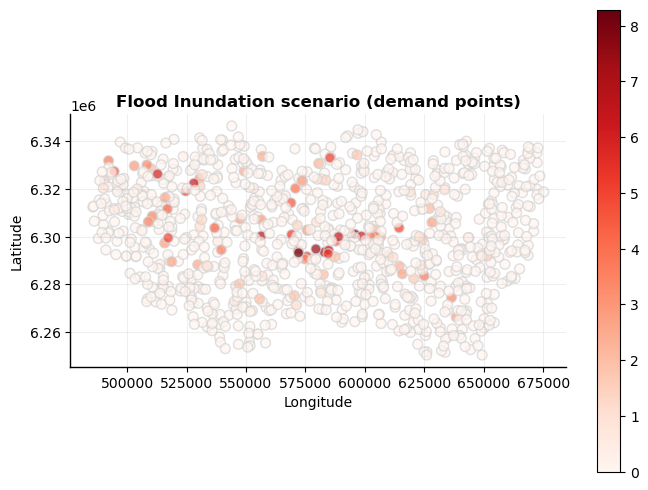

In [35]:
# Plot
fig, ax = plt.subplots(figsize=(8, 6))

gdf_data.plot(ax=ax, column="depth_y19_p250", cmap="Reds", legend=True, markersize=50, alpha=0.7, edgecolor="lightgray")

# 5. Ajustes do mapa
ax.set_title("Flood Inundation scenario (demand points)", fontsize=12, fontweight='bold')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#plt.colorbar(label='Height above nearest drainage (m)')
plt.grid(True, alpha=0.2) 

#Remove the box around the plot (except for the bottom and left borders)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1)  # Optionally, make the left border thicker
ax.spines['bottom'].set_linewidth(1)  # Op

plt.show()

**- Flood susceptibility-based demand scenario**

In [38]:
#gdf_data

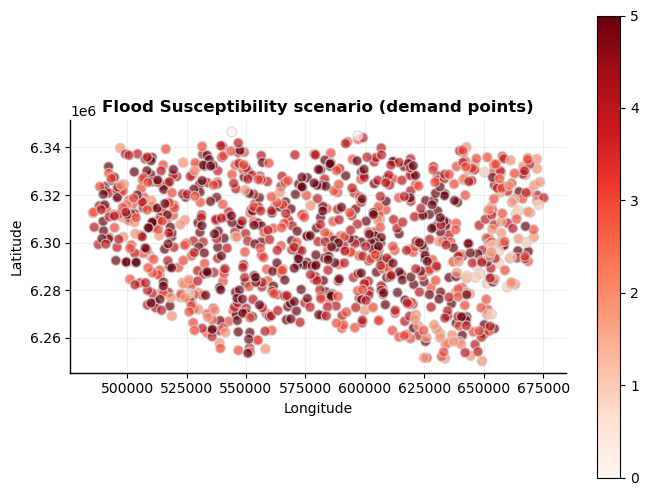

In [40]:
# Plot
fig, ax = plt.subplots(figsize=(8, 6))

gdf_data.plot(ax=ax, column="hand_class", cmap="Reds", legend=True, markersize=50, alpha=0.7, edgecolor="lightgray")

# 5. Ajustes do mapa
ax.set_title("Flood Susceptibility scenario (demand points)", fontsize=12, fontweight='bold')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#plt.colorbar(label='Height above nearest drainage (m)')
plt.grid(True, alpha=0.2)

#Remove the box around the plot (except for the bottom and left borders)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1)  # Optionally, make the left border thicker
ax.spines['bottom'].set_linewidth(1)  # Op

plt.show()

In [42]:
# Remover linhas com NaN na coluna 'hand_class'
teste = gdf_data.copy()
teste = teste.dropna(subset=['hand_class'])

#### 4.3. Gauge Stations Installed One by One

In this section, we explore the process of gradually deploying the monitoring network by installing sensors one by one. This process allows us to:
> Assess the impact of different network sizes, from minimal to maximum deployment.
> 
> Identify essential vs. redundant sensors as the network expands.
> 
> Optimize sensor placement by removing low-value stations and refining coverage.

With each new monitoring gauges allocation, we identify which ones remain essential and which might become redundant. Some gauges may become redundat as others are added, which leads us to adjust the final configuration for maximum efficiency.



**Change the number of gauges (*p*):**
> Use the *# p slider* to adjust the number of deployed sensors.
> 
>Observe how the coverage changes as more stations are added.

**Select the demand-based scenario:**

> Use the *Scenario dropdown menu* to explore different placement strategies:

 > *Flood Inundation* →  prioritize areas with higher floodwater depth.
>
 > *Flood Susceptibility* →  gauges are placed in high susceptibility flood-prone zones.


In [51]:
# Import data com coordenadas das estacoes/demandas
#data.head()

# Import data resultados otimizacao
df_op = pd.read_excel("data/result2cenarios.xlsx")
#df_op.head()

# Import the drainage network 
rede = gpd.read_file("data/vector/orderedNet_lines_2000.shp")
#rede.head()


In [53]:
# Pre processamento do dataframe de resultados 

import ast

df_result = df_op.copy()
#print(df_result.dtypes)
#print(df_result['ids_selecionadas'].apply(type).unique())

# Para converter strings seguras para listas

# Converter ids_selecionadas para listas de inteiros
df_result['ids_selecionadas'] = df_result['ids_selecionadas'].apply(ast.literal_eval)

# Conferir se a conversão foi bem-sucedida
#print(df_result['ids_selecionadas'].apply(type).unique())  # Deve retornar apenas <class 'list'>

In [55]:
import geopandas as gpd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display


In [57]:
# Dicionário para mapear os cenários

style = {'description_width': 'initial'} 

cenario_map = {
    'cenario01': 'Flood Inundation',
    'cenario02': 'Flood Susceptibility'
}

# Criar widgets interativos
cenario_widget = widgets.Dropdown(
    options=[(cenario_map[cenario], cenario) for cenario in df_result['cenario'].unique()],
    description='Scenario')

p_widget = widgets.IntSlider(value=df_result['p'].min(), min=df_result['p'].min(), max=df_result['p'].max(), step=1, 
                             description='p', layout=widgets.Layout(width='600px'))

def plot_solution(p, cenario):
    """Gera um mapa interativo mostrando as estações selecionadas e a rede de drenagem para um determinado p e cenário."""
    
    # Filtrar a solução correspondente ao cenário e p escolhidos
    solution = df_result[(df_result['p'] == p) & (df_result['cenario'] == cenario)]
    
    if solution.empty:
        print("Nenhuma solução encontrada para esses parâmetros.")
        return
    
    # Obter os IDs das estações selecionadas e número real de estações instaladas
    selected_ids = solution.iloc[0]['ids_selecionadas']
    num_estacoes_instaladas = solution.iloc[0]['num_estacoes']

    # Filtrar as estações selecionadas
    selected_stations = data[data['id'].isin(selected_ids)]
    
    # Criar a figura e o eixo do plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plotar a rede de drenagem (linhas)
    if 'rede' in globals():
        rede.plot(ax=ax, color='#00588D', linewidth=0.8, label='Drainage Network', alpha=0.6)

    # Plotar todas as estações como referência
    data.plot(ax=ax, color='lightgray', markersize=10, label='Demand points')

    # Plotar as estações selecionadas com marcador específico
    selected_stations.plot(ax=ax, color='#A81829', markersize=40, marker='^', label='Gauge stations')  # Triângulo

    # Ajustar título com número de estações instaladas
    ax.set_title(f'Scenario: {cenario_map[cenario]} | p = {p} | Gauges allocated: {num_estacoes_instaladas}', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend()

    #Remove the box around the plot (except for the bottom and left borders)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1)  # Optionally, make the left border thicker
    ax.spines['bottom'].set_linewidth(1)  # Op

    plt.show()

# Criar widget interativo
interactive_plot = widgets.interactive(plot_solution, p=p_widget, cenario=cenario_widget)

# Exibir os widgets
display(interactive_plot)


interactive(children=(IntSlider(value=1, description='p', layout=Layout(width='600px'), max=419, min=1), Dropd…

### Conclusions & Research Contributions

This notebook is part of a research aimed to provide a flexible and adaptive framework for optimizing the placement of monitoring gauge stations in river networks. By integrating hydrological modeling, spatial analysis, and optimization, we provide a systematic approach to support decision-making in flood monitoring and risk management.

**Key contributions:**
- The stepwise allocation approach allows for a progressive evaluation of gauge stations placement, ensuring that each added gauge provides meaningful additional value.
- By analyzing the evolution of the network, we can identify critical points where additional sensors no longer improve coverage significantly, allowing for a cost-effective deployment.
  
- The optimization process highlights high-priority areas where sensors should be installed first, ensuring maximum coverage with minimal infrastructure.
- This is particularly useful for resource-limited scenarios, where only a subset of the network can be initially installed.

- The framework can be adapted to different monitoring objectives, such as flood depth vs. flood susceptibility, enabling decision-makers to adjust station placement based on the most relevant priority at any given time.
- By incorporating flood inundation maps and flood susceptibility data, the framework ensures that monitoring stations are positioned based on real risk factors, rather than arbitrary spatial criteria.


In [62]:
#!pip freeze > requirements.txt